# Cleaning raw data2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import os

In [2]:
xlsx_path = "../input_folder/dataset_2020-2023_RanaK.xlsx"

In [3]:
yrs = ["2020", "2021", "2022", "2023"]
dfs = []

def read_raw_data(yr):
    df = pd.read_excel(xlsx_path, sheet_name=yr)
    df.set_index("ID2", drop=False, inplace=True)

    # clean string columns
    for c in ["Gender", "Ward", 'Type of Sample']:
        df[c] = df[c].str.strip().str.title()

    df["Type of Sample"] = df["Type of Sample"].str.replace("Stool Cluture", "Stool Culture")
    df["Type of Sample"] = df["Type of Sample"].str.replace("Peritonial Fluid", "Peritoneal Fluid")
    
    for c in ["Organism"]:
        df[c] = df[c].str.strip().str.capitalize()

    to_replace = {
        'Acinetobacter baumanii': 'Acinetobacter baumannii',
        'Aeromonas hydrophilia': 'Aeromonas hydrophila',
        'Bacteroides species': 'Bacteroides spp',
        'Enterobacteriacae': 'Enterobacteriaceae',
        'Flaviobacterium spp': 'Flavobacterium spp',
        'Klebsiella spp.': 'Klebsiella spp',
        'Micrococcus species': 'Micrococcus spp',
        'Providencia  stuartii': 'Providencia stuartii',
        'Streptococcus group c': 'Streptococcus Group C'
    }
    
    df["Organism"] = df["Organism"].replace(to_replace)

    for c in ["Type of AMR"]:
        df[c] = df[c].str.strip()
    #df[col] = df[col].method(value)
    df["Type of AMR"] = df["Type of AMR"].replace({"": np.nan, "-": np.nan})
    
    df["Year"] = int(yr)
    # df["Year"] = pd.to_datetime(yr, format="%Y")
    
    df['Date of Birth'] = pd.to_datetime(df['Date of Birth'], format='%d/%m/%Y')
    reference_date = pd.Timestamp('2025-02-01')
    df['Age'] = (reference_date - df['Date of Birth']).dt.days // 365

    df['Date of Request'] = pd.to_datetime(df['Date of Request'], format='%d/%m/%Y')
    
    return df

    
for yr in yrs:
    sdf = read_raw_data(yr)
    dfs.append(sdf)

df = pd.concat(dfs)
df.sort_values("Year", inplace=True)


In [4]:
print(f"Number of rows: {df.shape[0]}")

Number of rows: 18802


Columns: 

In [5]:
df.columns.tolist()

['ID',
 'ID2',
 'Gender',
 'Date of Birth',
 'Age',
 'Ward',
 'Type of Sample',
 'Date of Request',
 'Organism',
 'Type of AMR',
 'Year']

Cleaning data, problems from raw data:

- Gender: `['Male', 'Female', 'Male ', 'male ']`
- Date of Birth
- Age

Dates, I'm assuming it follows the format `%d/%m/%Y`, and I recalculate age too.

## How many entries per year?

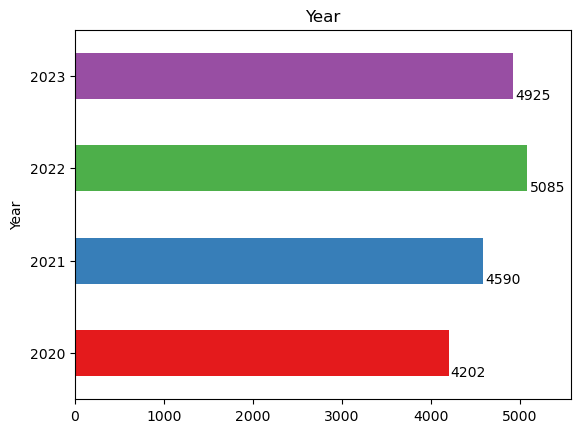

In [6]:
a = df["Year"].value_counts()
a = a[[2020, 2021, 2022, 2023]]
ax = a.plot(kind="barh", color=plt.cm.Set1.colors)

for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y()))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)

plt.title("Year")
plt.show()

## Gender

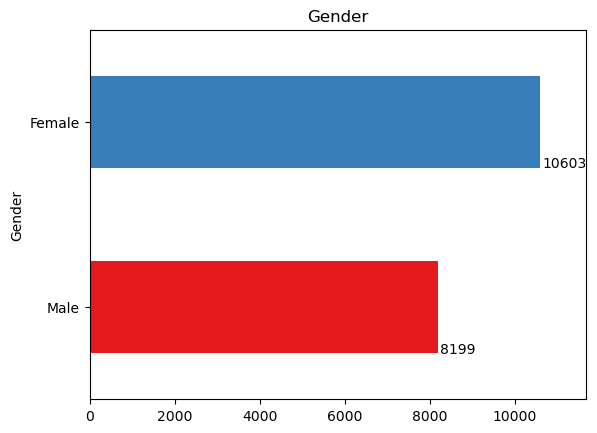

In [7]:
ax = df['Gender'].value_counts(ascending=True).plot(kind="barh", color=plt.cm.Set1.colors)
for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y() * 1.005))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)
ax.set_title("Gender")

plt.show()

## Date of Birth

In [8]:
eldest = df["Date of Birth"].min()
youngest = df["Date of Birth"].max()

print(f"""Eldest: {eldest},
Youngest: {youngest}""")

Eldest: 1914-01-01 17:18:35,
Youngest: 2023-12-24 10:15:28


## Age

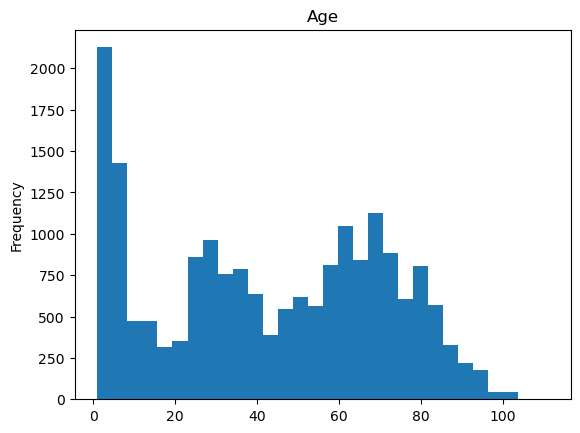

In [9]:
df["Age"].sort_values().plot(kind="hist", bins=30)
plt.title("Age")
plt.show()

## Date of Request

In [10]:
for yr in yrs:
    yr = int(yr)
    earliest = df.loc[df["Year"] == yr, :]["Date of Request"].min()
    latest = df.loc[df["Year"] == yr, :]["Date of Request"].max()
    
    
    print(f"""Year: {yr},
    Earliest: {earliest},
    Latest: {latest}""")
    print()

Year: 2020,
    Earliest: 2020-01-01 00:00:00,
    Latest: 2020-12-01 00:00:00

Year: 2021,
    Earliest: 2021-01-01 00:00:00,
    Latest: 2021-12-01 00:00:00

Year: 2022,
    Earliest: 2022-01-01 00:00:00,
    Latest: 2022-12-01 00:00:00

Year: 2023,
    Earliest: 2023-01-01 00:00:00,
    Latest: 2023-12-31 09:14:28



Something weird going on with the date:

- Most of the years, sample collection ended on 1st Dec?
- Earliest sample on 2023 is on 1st June?

## Ward

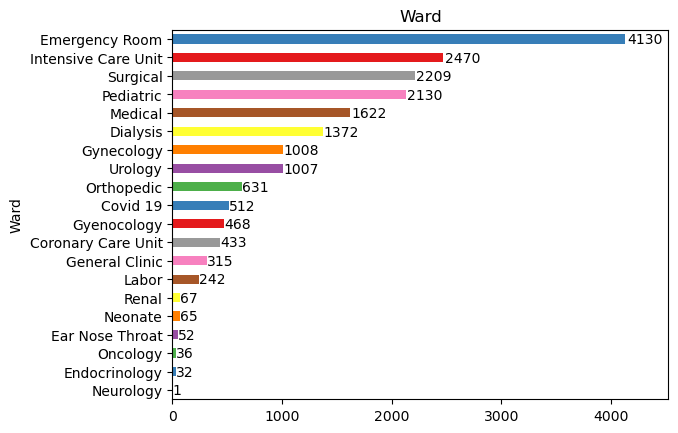

In [11]:
ax = df['Ward'].value_counts(ascending=True).plot(kind="barh", color=plt.cm.Set1.colors)
for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y()))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)
ax.set_title("Ward")

plt.show()

## Type of Sample

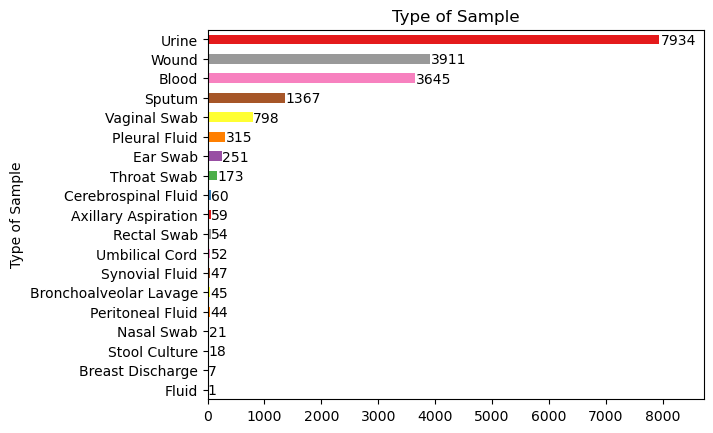

In [12]:
ax = df['Type of Sample'].value_counts(ascending=True).plot(kind="barh", color=plt.cm.Set1.colors)
for p in ax.patches:
    ax.annotate(str(p.get_width()), ( p.get_width() * 1.005, p.get_y()))

ax.set_xlim(0, ax.get_xlim()[1]**1.005)
ax.set_title("Type of Sample")

plt.show()

## Organism

In [13]:
org = df['Organism'].value_counts().to_dict()
org = dict(sorted(org.items()))
all_organisms = list(org.keys())

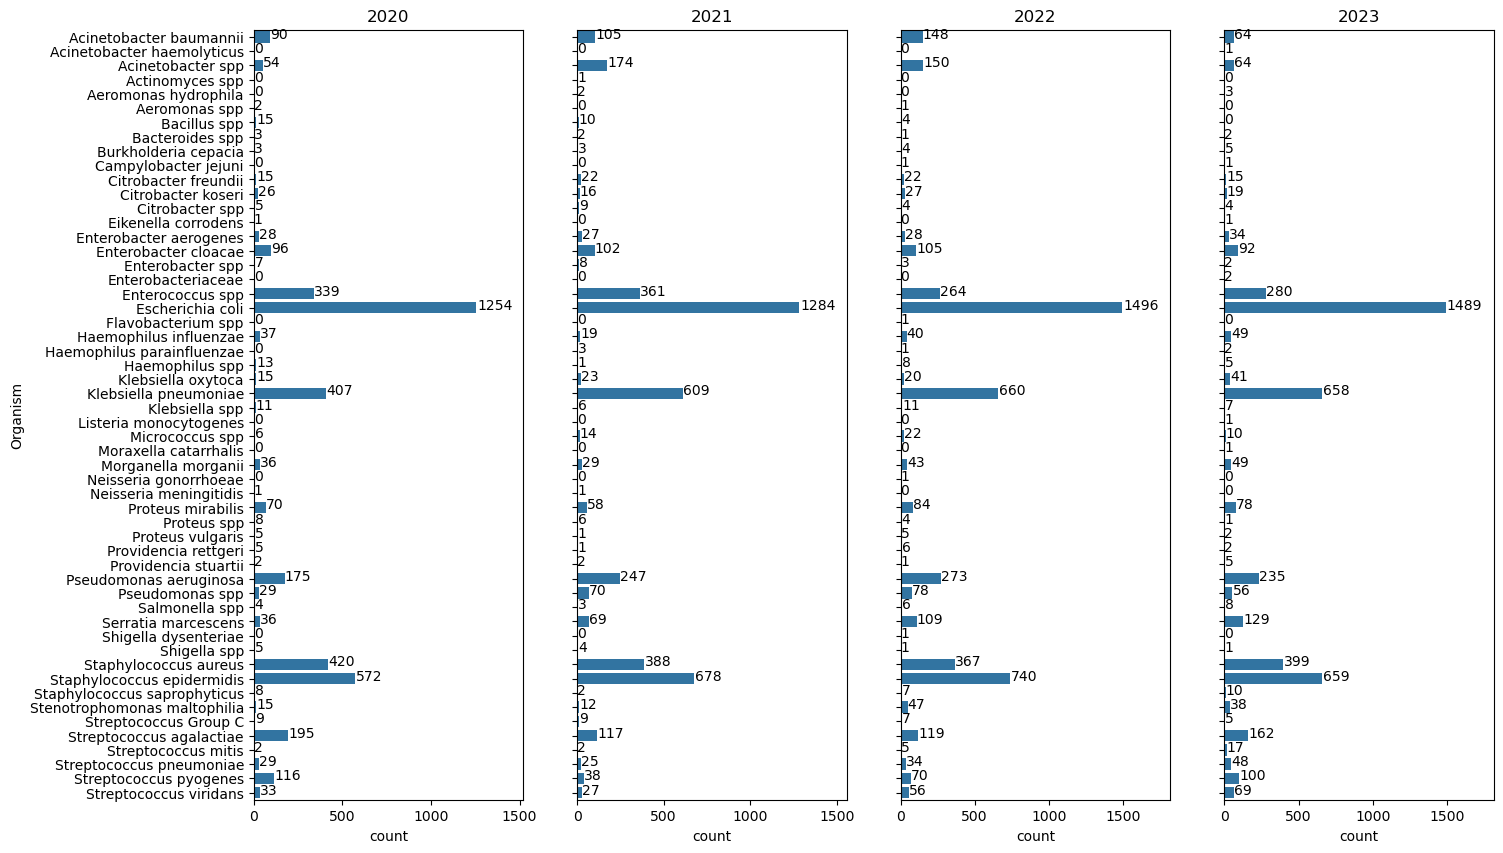

In [14]:
fig, axs = plt.subplots(ncols = 4, figsize=(16,10), dpi=100, sharey=True)
axs = axs.ravel()

# yearly_counts = {}

for idx, yr in enumerate(yrs):
    yr = int(yr)

    subset = df.loc[df["Year"] == yr, :].value_counts("Organism")
    subset = subset.reindex(all_organisms, fill_value=0)  # Fill missing organisms with 0
    subset = pd.DataFrame(subset)
    # yearly_counts[yr] = subset
    subset["count"] = subset["count"].astype(int)
    # subset["count"] = subset["count"].round()

    ax = axs[idx]
    sns.barplot(data=subset, x="count", y=subset.index, ax=ax)

    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), ( p.get_width() * 1.005, p.get_y()+0.5))
    ax.set_xlim(0, ax.get_xlim()[1]**1.02)
    
    ax.set_title(yr)

plt.show()

## Type of AMR

In [15]:
amrs = df['Type of AMR'].value_counts().to_dict()
amrs = dict(sorted(amrs.items()))
all_amrs = list(amrs.keys())

Types of AMR:

In [16]:
all_amrs

['AMP-RHI',
 'CR-AB',
 'CR-PA',
 'CRE',
 'CRE CP Producer',
 'ESBL-EC',
 'ESBL-KP',
 'MAC-RSP',
 'MAC-RSPN',
 'MRSA',
 'MRSE',
 'PEN-R',
 'VRE']

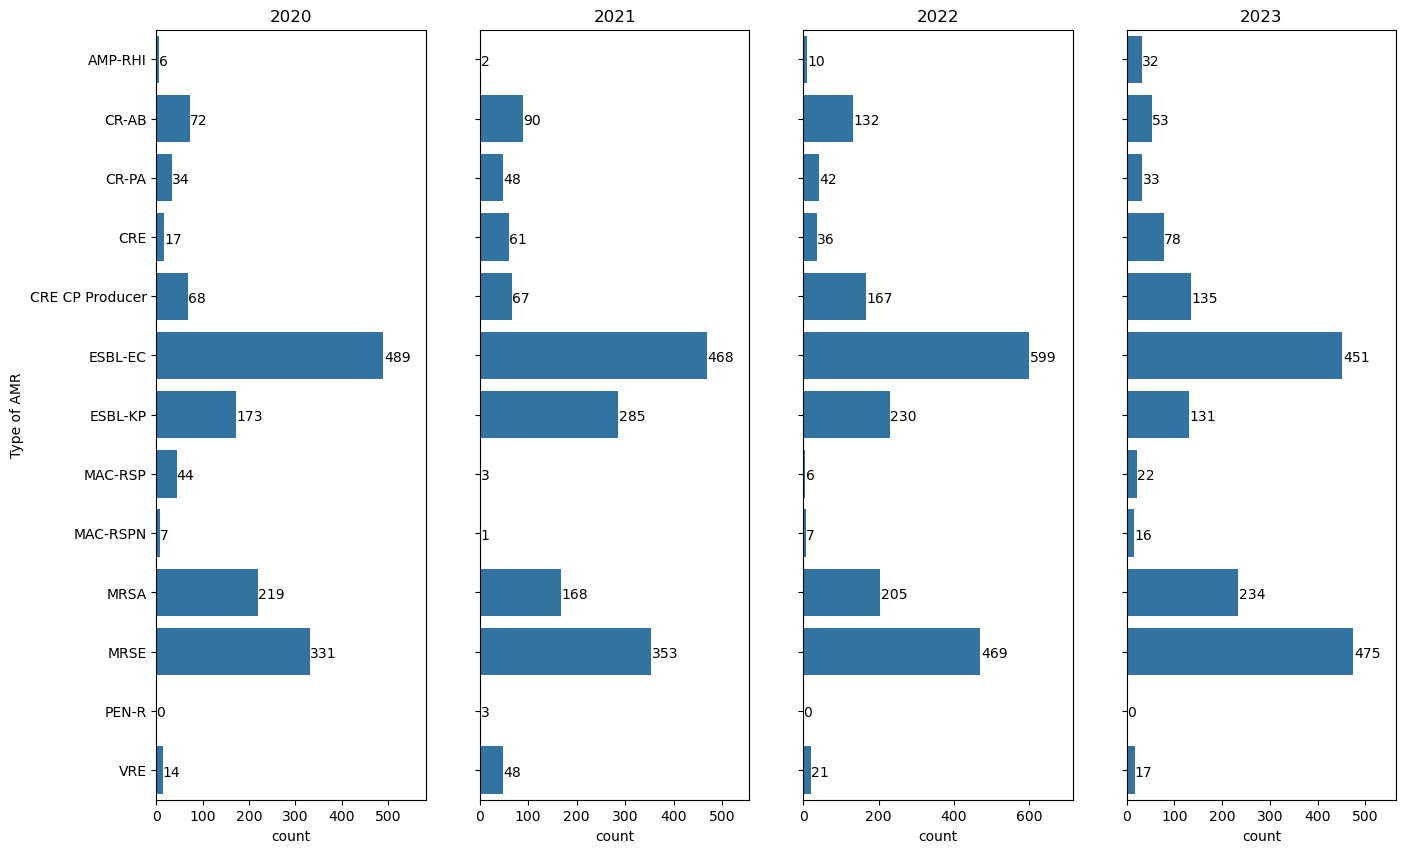

In [17]:
fig, axs = plt.subplots(ncols = 4, figsize=(16,10), dpi=100, sharey=True)
axs = axs.ravel()


for idx, yr in enumerate(yrs):
    yr = int(yr)

    subset = df.loc[df["Year"] == yr, :].value_counts("Type of AMR")
    subset = subset.reindex(all_amrs, fill_value=0)  # Fill missing organisms with 0
    subset = pd.DataFrame(subset)
    
    subset["count"] = subset["count"].astype(int)
    
    ax = axs[idx]
    sns.barplot(data=subset, x="count", y=subset.index, ax=ax)

    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), ( p.get_width() * 1.005, p.get_y()+0.5))
    ax.set_xlim(0, ax.get_xlim()[1]**1.02)
    
    ax.set_title(yr)

plt.show()

# QnA

1. What is the Number of samples per year?

In [18]:
df["Year"].value_counts()

Year
2022    5085
2023    4925
2021    4590
2020    4202
Name: count, dtype: int64

2. Which organism is the most frequently isolated across all years?

In [19]:
pd.DataFrame(df["Organism"].value_counts())

,count
Organism,
Escherichia coli,5523
Staphylococcus epidermidis,2649
Klebsiella pneumoniae,2334
Staphylococcus aureus,1574
Enterococcus spp,1244
Pseudomonas aeruginosa,930
Streptococcus agalactiae,593
Acinetobacter spp,442
Acinetobacter baumannii,407


3. What are the most common organisms isolated from the group of samples?

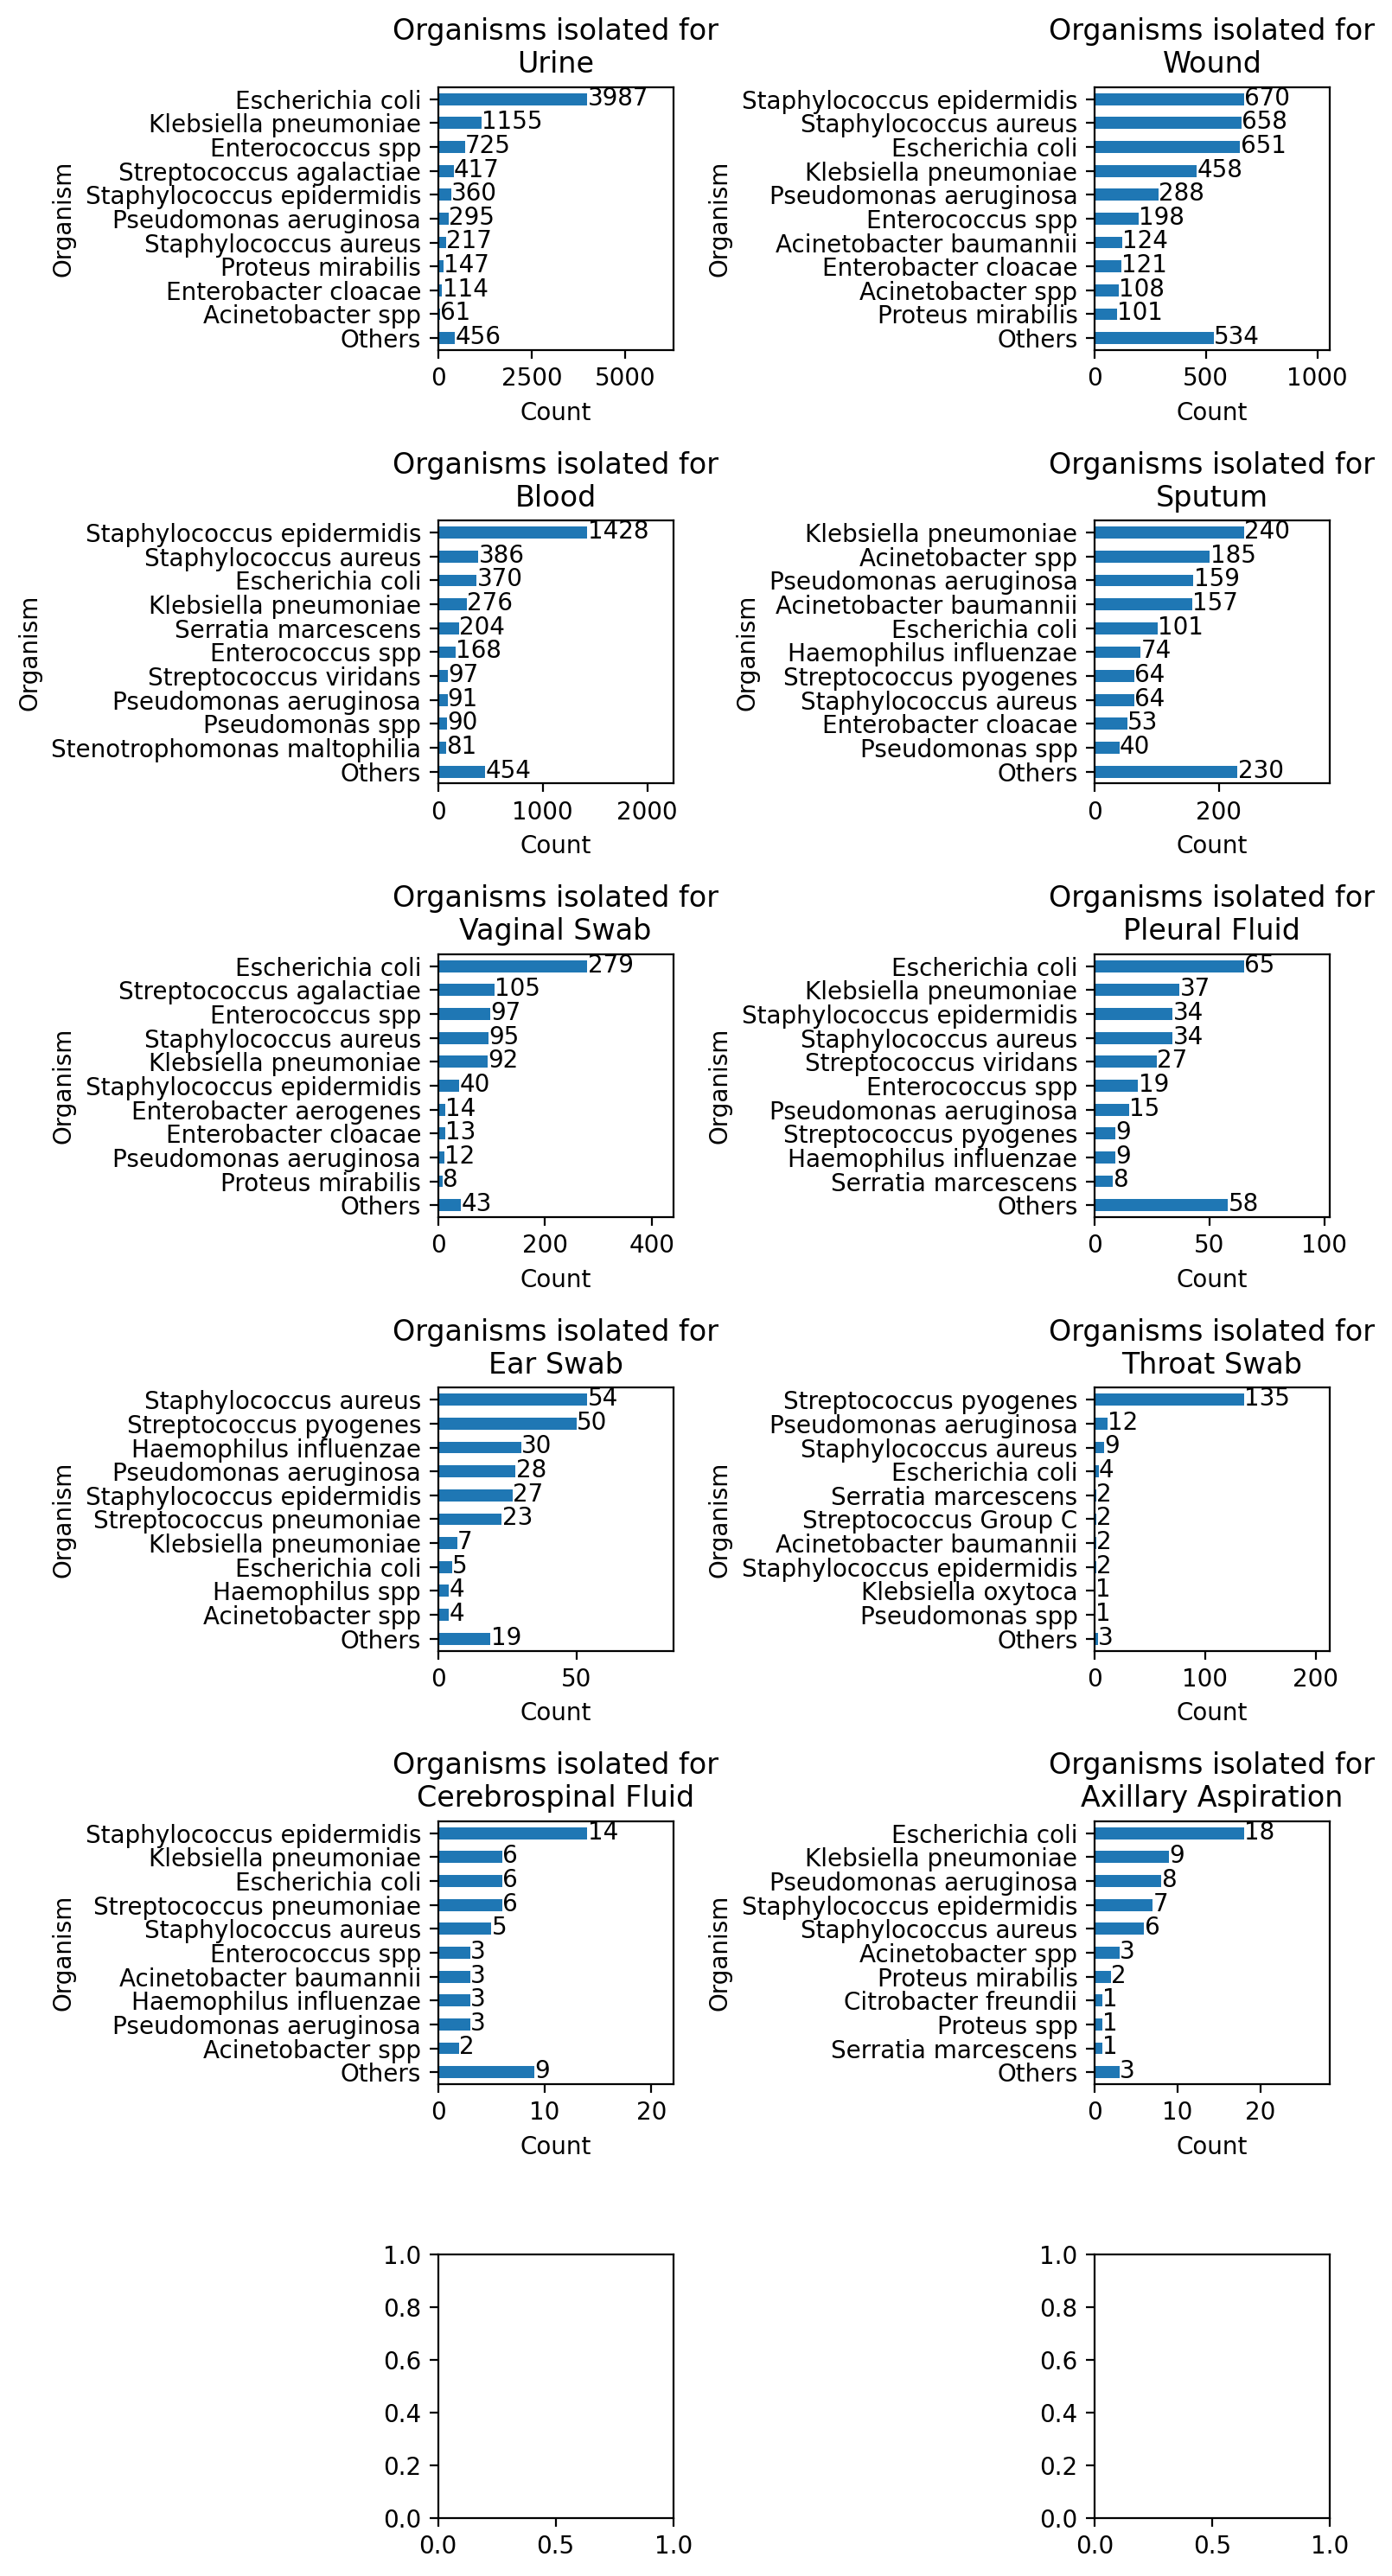

In [20]:
# example: for blood samples, what are the common isolated organisms

tos = df['Type of Sample'].value_counts(ascending=False).index.tolist()[:10]

fig, axs = plt.subplots(nrows=len(tos)//2 + 1, ncols=2, figsize=(8, 1.5 * len(tos)), dpi=200)
axs = axs.ravel()

for i, t in enumerate(tos):
    sdf = df.loc[df["Type of Sample"] == t, :]
    counts = sdf["Organism"].value_counts(ascending=True)
    
    if len(counts) > 10:
        top_counts = counts.iloc[-10:]  # Keep the 10 most common
        original_index = top_counts.index.tolist()
        others_sum = counts.iloc[:-10].sum()  # Sum the remaining
        top_counts["Others"] = others_sum  # Add "Others" category
    else:
        top_counts = counts

    if len(counts) > 10:
        final_index = ["Others"] + original_index
        top_counts = top_counts.loc[final_index]
        
    ax = axs[i]
    top_counts.plot(kind="barh", ax=ax)
    ax.set_title(f"Organisms isolated for\n{t}")
    ax.set_xlabel("Count")
    ax.set_ylabel("Organism")

    for p in ax.patches:
        ax.annotate(str(int(p.get_width())), (p.get_width() * 1.005, p.get_y()))

    ax.set_xlim(0, ax.get_xlim()[1] * 1.5)

plt.tight_layout()
plt.show()

4. What is the percentage of AMR from all the samples?

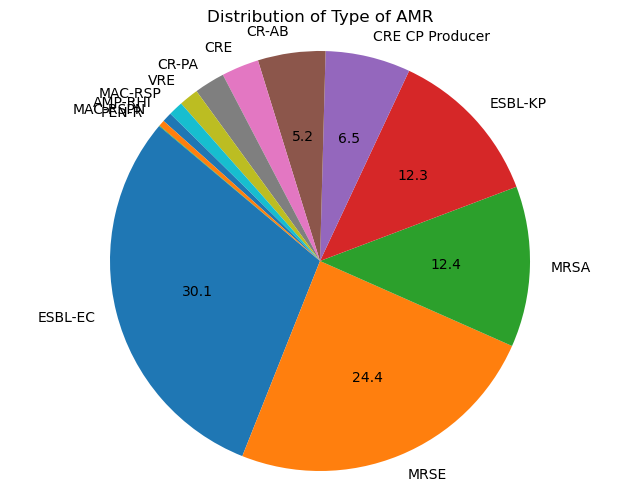

In [21]:
# Count occurrences
counts = df["Type of AMR"].value_counts()

# Get the top 4 largest categories
top_4_indices = counts.nlargest(4).index  

# Custom function to display percentages only for top 4 slices
def custom_autopct(pct, all_values):
    absolute = int(round(pct / 100. * sum(all_values)))  # Get the count from percentage
    ans = ""
    if pct > 5:
        ans = f"{pct:.1f}"
    return ans
    # return f"{pct:.1f}%" if absolute in all_values[top_4_indices] else ""

# Plot pie chart
plt.figure(figsize=(8, 6))
pie = counts.plot(kind="pie", 
                  autopct=lambda pct: custom_autopct(pct, counts),  # Apply custom labeling
                  startangle=140)

# Formatting
plt.title('Distribution of Type of AMR')
plt.ylabel('')
plt.axis('equal')  # Ensures the pie chart is circular

# Show plot
plt.show()

5. Which ward/clinic reports the highest rate of antimicrobial resistance?

In [22]:
amr = {}

for w in df["Ward"].unique():
    a = df.loc[df["Ward"] == w, :].value_counts("Type of AMR")
    amr[w] = a

amr = pd.DataFrame.from_dict(amr, orient="index")
amr["SUM"] = amr.sum(axis="columns")
amr.sort_values("SUM", ascending = False)

,ESBL-EC,MRSE,MRSA,ESBL-KP,CR-AB,CRE,AMP-RHI,CR-PA,MAC-RSP,CRE CP Producer,MAC-RSPN,VRE,PEN-R,SUM
Intensive Care Unit,146.0,328.0,126.0,133.0,147.0,78.0,1.0,52.0,4.0,183.0,5.0,26.0,1.0,1230.0
Emergency Room,545.0,197.0,171.0,145.0,15.0,20.0,17.0,20.0,18.0,42.0,8.0,6.0,NaN,1204.0
Surgical,255.0,229.0,129.0,96.0,55.0,27.0,9.0,21.0,19.0,71.0,5.0,26.0,NaN,942.0
Pediatric,255.0,232.0,90.0,79.0,3.0,7.0,2.0,6.0,11.0,20.0,3.0,3.0,NaN,711.0
Medical,207.0,113.0,53.0,80.0,16.0,23.0,10.0,24.0,14.0,37.0,4.0,13.0,NaN,594.0
Dialysis,76.0,254.0,75.0,49.0,1.0,5.0,NaN,2.0,NaN,20.0,NaN,13.0,NaN,495.0
Urology,164.0,22.0,21.0,51.0,2.0,5.0,NaN,7.0,NaN,19.0,NaN,4.0,NaN,295.0
Orthopedic,49.0,57.0,48.0,31.0,15.0,8.0,1.0,9.0,4.0,20.0,1.0,4.0,NaN,247.0
Gynecology,105.0,39.0,29.0,50.0,1.0,6.0,NaN,NaN,NaN,2.0,NaN,1.0,2.0,235.0
Covid 19,47.0,28.0,19.0,28.0,85.0,2.0,1.0,7.0,2.0,7.0,1.0,2.0,NaN,229.0


6. Time series analysis for the AMR organisms by month?

In [23]:
yms = []
for y in range(2020, 2024):
    for m in range(1,13):
        yms.append(f"{m}-{y}")
# print(yms)

In [24]:
plt.style.use("ggplot")

/tmp/ipykernel_16064/1196302888.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40)


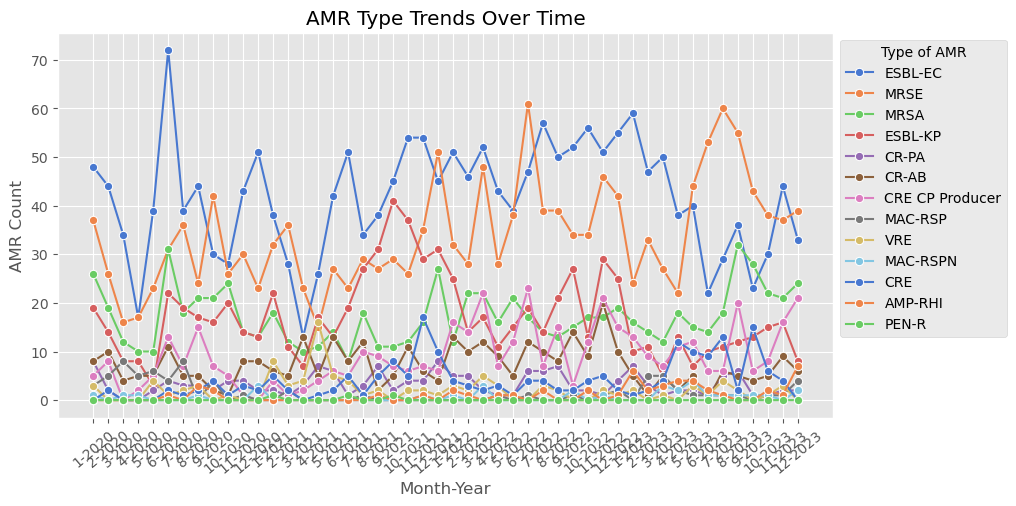

In [25]:
df2 = df.copy()
df2["Month-Year"] = df2["Date of Request"].dt.month.astype(str) + "-" + df2["Date of Request"].dt.year.astype(str)

ts = {}

for my in yms:
    a = df2.loc[df2["Month-Year"] == my, :].value_counts("Type of AMR")
    ts[my] = a

ts = pd.DataFrame.from_dict(ts, orient="index")
ts.replace(np.nan, 0, inplace=True)


ts = ts.reset_index().melt(id_vars="index", var_name="AMR Type", value_name="Count")
ts = ts.rename(columns={"index": "Month-Year"})

# Plotting with seaborn
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=ts, x="Month-Year", y="Count", hue="AMR Type", marker="o", palette="muted", ax=ax)

ax.set_xlabel("Month-Year")
ax.set_ylabel("AMR Count")
ax.set_title("AMR Type Trends Over Time")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)
ax.legend(title="Type of AMR", bbox_to_anchor=(1, 1), loc="upper left")
# plt.grid(True)
plt.show()

7. Is there a correlation between patient age and Type of AMR Infections?

8. What percentage of E. coli isolates are ESBL-positive?

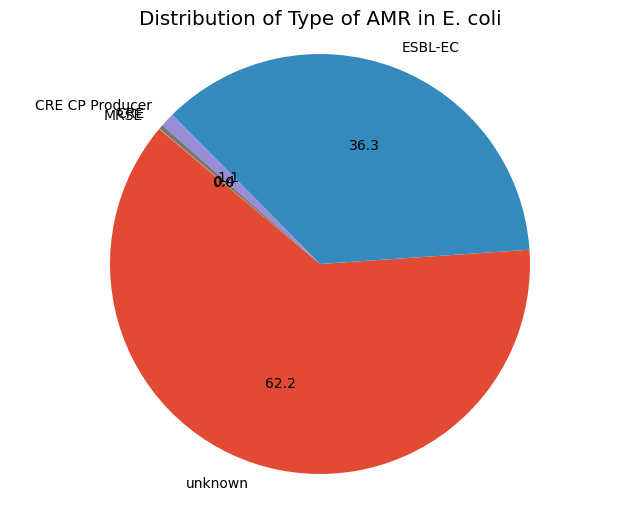

In [26]:
ecoli = df.loc[df["Organism"] == "Escherichia coli", :]
ecoli.loc[:, "Type of AMR"] = ecoli.loc[:, "Type of AMR"].fillna("unknown")
counts = ecoli["Type of AMR"].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
pie = counts.plot(kind="pie", 
                  autopct='%.1f',  # Apply custom labeling
                  startangle=140)

# Formatting
plt.title('Distribution of Type of AMR in E. coli')
plt.ylabel('')
plt.axis('equal')  # Ensures the pie chart is circular

# Show plot
plt.show()

9. What percentage of Klebsiella pneumoniae isolates are ESBL-positive?

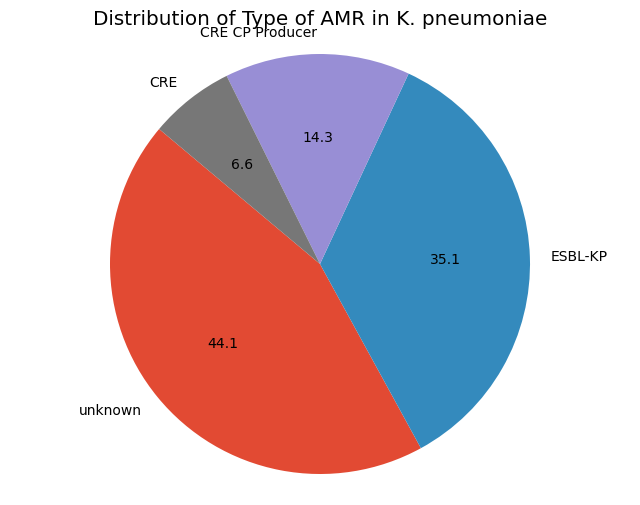

In [27]:
kp = df.loc[df["Organism"] == "Klebsiella pneumoniae", :]
kp.loc[:, "Type of AMR"] = kp.loc[:, "Type of AMR"].fillna("unknown")
counts = kp["Type of AMR"].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
pie = counts.plot(kind="pie", 
                  autopct='%.1f',  # Apply custom labeling
                  startangle=140)

# Formatting
plt.title('Distribution of Type of AMR in K. pneumoniae')
plt.ylabel('')
plt.axis('equal')  # Ensures the pie chart is circular

# Show plot
plt.show()

10. What percentage of Pseudomonas aeruginosa isolates are CR-PA?

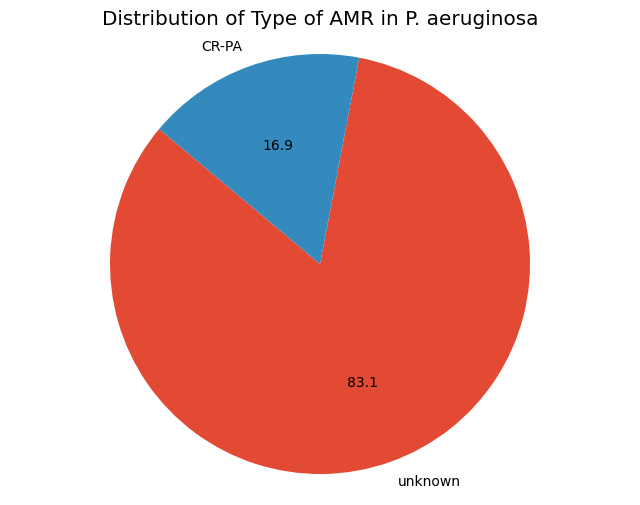

In [28]:
pa = df.loc[df["Organism"] == "Pseudomonas aeruginosa", :]
pa.loc[:, "Type of AMR"] = pa.loc[:, "Type of AMR"].fillna("unknown")
counts = pa["Type of AMR"].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 6))
pie = counts.plot(kind="pie", 
                  autopct='%.1f',  # Apply custom labeling
                  startangle=140)

# Formatting
plt.title('Distribution of Type of AMR in P. aeruginosa')
plt.ylabel('')
plt.axis('equal')  # Ensures the pie chart is circular

# Show plot
plt.show()

11. What sample type contributes the most to ESBL-producing E. coli detection?

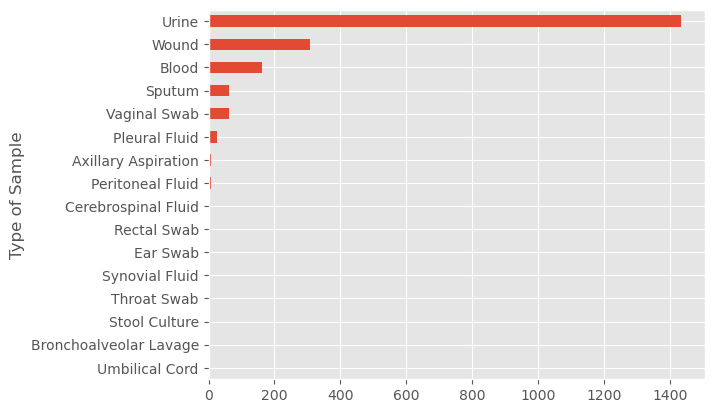

In [29]:
ecoli = df.loc[df["Organism"] == "Escherichia coli", :]
ecoli.loc[:, "Type of AMR"] = ecoli.loc[:, "Type of AMR"].fillna("unknown")
ecoli = ecoli.loc[ecoli["Type of AMR"] != "unknown", :]
ecoli["Type of Sample"].value_counts(ascending=True).plot(kind="barh")
plt.show()

12. Are there particular wards or patient groups with a higher prevalence of ESBL-producing organisms?

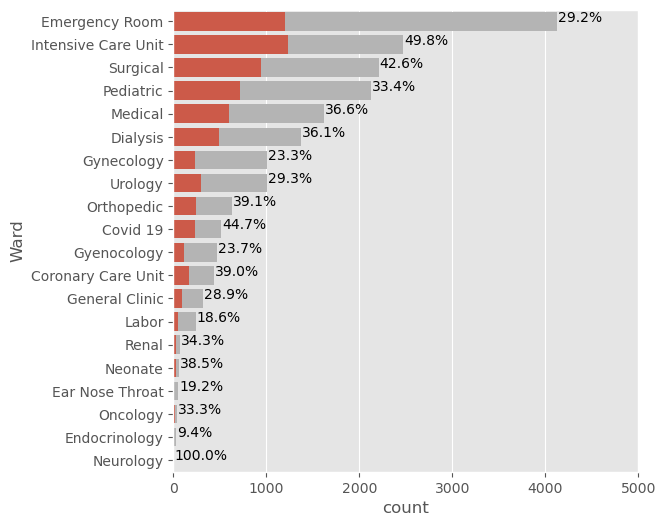

In [30]:
df2 = df.copy()
b1 = df2["Ward"].value_counts()

df2.loc[:, "Type of AMR"] = df2.loc[:, "Type of AMR"].fillna("unknown")
df2 = df2.loc[df2["Type of AMR"] != "unknown", :]
b2 = df2["Ward"].value_counts()

b = pd.DataFrame([b1, b2]).T
b.columns = ["all", "ESBL"]

fig, ax = plt.subplots(figsize=(6,6))

sns.barplot(b.loc[:, "all"], orient="h", color="#b4b4b4", ax=ax)
sns.barplot(b.loc[:, "ESBL"], orient="h", ax=ax)

c = b["ESBL"]/b["all"]*100
c = c.to_dict()

for w, pct in c.items():
    x = b1[w]+10
    ax.annotate(f"{pct:.1f}%", xy=(x, w))

ax.set_xlabel("count")
ax.set_xlim(0, 5000)
plt.show()

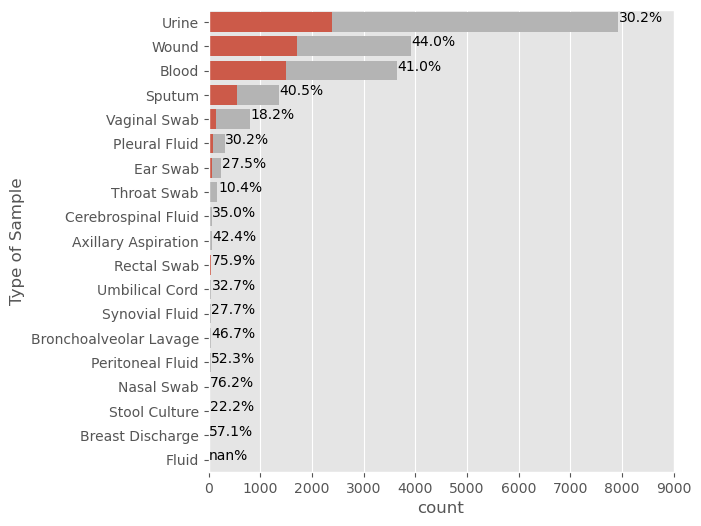

In [31]:
df2 = df.copy()
b1 = df2["Type of Sample"].value_counts()

df2.loc[:, "Type of AMR"] = df2.loc[:, "Type of AMR"].fillna("unknown")
df2 = df2.loc[df2["Type of AMR"] != "unknown", :]
b2 = df2["Type of Sample"].value_counts()

b = pd.DataFrame([b1, b2]).T
b.columns = ["all", "ESBL"]

fig, ax = plt.subplots(figsize=(6,6))

sns.barplot(b.loc[:, "all"], orient="h", color="#b4b4b4", ax=ax)
sns.barplot(b.loc[:, "ESBL"], orient="h", ax=ax)

c = b["ESBL"]/b["all"]*100
c = c.to_dict()

for w, pct in c.items():
    x = b1[w]+10
    ax.annotate(f"{pct:.1f}%", xy=(x, w))

ax.set_xlabel("count")
ax.set_xlim(0, 9000)
plt.show()

13. What are the trends in antibiotic resistance among E. coli, Klebsiella pneumoniae, Acinetobacter baumannii, and Staphylococcus aureus over the four years?

** maybe you want to check out these numbers first

In [32]:
def count_amr_in_species(species):
    counyer = df.loc[df["Organism"] == species, :]
    counyer.loc[:, "Type of AMR"] = counyer.loc[:, "Type of AMR"].fillna("unknown")

    e1 = {}

    for yr in range(2020, 2024):
        d = counyer.loc[counyer["Year"] == yr, :].groupby("Type of AMR").count()["ID"]
        e1[yr] = d

    return pd.DataFrame(e1)

Escherichia coli

In [33]:
count_amr_in_species("Escherichia coli")

,2020,2021,2022,2023
Type of AMR,,,,
CRE,2.0,7,6.0,5.0
CRE CP Producer,15.0,8,19.0,18.0
ESBL-EC,489.0,468,599.0,451.0
MRSE,NaN,1,NaN,NaN
unknown,748.0,800,872.0,1015.0


Klebsiella pneumoniae

In [34]:
count_amr_in_species("Klebsiella pneumoniae")

,2020,2021,2022,2023
Type of AMR,,,,
CRE,14,44,27,68
CRE CP Producer,46,48,135,104
ESBL-KP,173,285,230,131
unknown,174,232,268,355


Acinetobacter baumannii

In [35]:
count_amr_in_species("Acinetobacter baumannii")

,2020,2021,2022,2023
Type of AMR,,,,
CR-AB,72,90,132,53
unknown,18,15,16,11


Staphylococcus aureus

In [36]:
count_amr_in_species("Staphylococcus aureus")

,2020,2021,2022,2023
Type of AMR,,,,
MRSA,219.0,168,205.0,234.0
MRSE,NaN,3,NaN,NaN
unknown,201.0,217,162.0,165.0
